In [1]:
import pandas as pd
from pandas_datareader import DataReader
import numpy as np
import tensorflow as tf
from tensorflow import keras
import preprocessing as pp
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, CuDNNLSTM, Dropout
from tensorflow.keras.models import Sequential

%matplotlib inline
# Limit vRAM
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=tf_config)

In [2]:
start_date = '1-1-2006'
end_date = '1-1-2018'
apple_stock = DataReader('IBM', 'yahoo', start=start_date, end=end_date)

In [3]:
apple_stock.shape

(3020, 6)

# 思路:
-  把每50天拼凑成一个样本, 然后标签为50+1


In [4]:
from sklearn.preprocessing import MinMaxScaler


def data_organize(raw_datas, start_index, end_index):
    sc = MinMaxScaler(feature_range=(0, 1))
    datas = sc.fit_transform(raw_datas.values)

    features = np.array([])
    labels = np.array([])
    for i in range(start_index, end_index):
        features_10 = np.array([])
        features_10 = np.append(features_10, datas[i:i+50])
        features_10 = features_10.reshape(50, 6)

        features = np.append(features, features_10)
        features = features.reshape(-1, 50, 6)

        labels_10 = np.array([])
        labels_10 = np.append(labels_10, datas[50+i])
        labels_10 = labels_10.reshape(1, 6)

        labels = np.append(labels, labels_10)
        labels = labels.reshape(-1,6)
        
        period = raw_datas.index[start_index:end_index]
    print(features.shape, labels.shape,"\nTotal days: ",period.shape)
    print("")

    return features, labels,period

In [5]:
x_train, y_train,train_period = data_organize(apple_stock, 0, 2000)
x_test, y_test,test_period = data_organize(apple_stock, 2000, 2200)

(2000, 50, 6) (2000, 6) 
Total days:  (2000,)

(200, 50, 6) (200, 6) 
Total days:  (200,)



In [6]:
# 图像显示趋势
def plot(prediction, target, dataframe):
    
    index_num = len(list(dataframe.columns.values))
    cols = int(index_num/3)
    rows = int(np.ceil(index_num/cols))
    plt.figure(figsize=(15, 12))
    for row in range(rows):
        for col in range(cols):
            index = cols * row + col + 1
            plt.subplot(rows, cols, index,
                        title=dataframe.columns.values[index-1])
            plt.plot(prediction[:, index-1], label='prediction')
            plt.plot(target[:, index-1], label='target')
            plt.tight_layout()
            plt.xlabel('Date', fontweight='bold')
            plt.yticks([])
            plt.legend()
    plt.savefig("Stock_prediction.pdf",dpi=2000,bbox_inches='tight')

In [7]:
# 趋势预测
def tendency_predict(days,features):
    pred = features[0].reshape(1,50,6)
    final_result = np.array([])
    final_target = np.array([])
    for i in range(days):
        

        rlt = model.predict(pred)
        pred = np.append(pred,rlt)
        pred = pred.reshape(1,-1,6)[0][-50:].reshape(1,-1,6)

        final_result = np.append(final_result,rlt)
        
        target = features[i+1,49]
        final_target = np.append(final_target,target)
    final_result = final_result.reshape(-1,6)
    final_target = final_target.reshape(-1,6)
    
    return final_result, final_target

# 构造模型

In [8]:
model = Sequential()

model.add(CuDNNLSTM(64, input_shape=(50, 6), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(64))


model.add(Dense(32))
model.add(Dropout(0.2))

model.add(Dense(6))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
adam = keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['acc']
              )

Instructions for updating:
Use tf.cast instead.


In [10]:
model.fit(x_train, y_train, epochs=50,
          batch_size=32, validation_split=0.1)

Train on 1800 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1800/1800 [==============================] - ETA: 1:37 - loss: 0.2358 - acc: 0.250 - ETA: 18s - loss: 0.1466 - acc: 0.206 - ETA: 9s - loss: 0.0927 - acc: 0.1806 - ETA: 7s - loss: 0.0768 - acc: 0.221 - ETA: 5s - loss: 0.0647 - acc: 0.212 - ETA: 4s - loss: 0.0584 - acc: 0.212 - ETA: 3s - loss: 0.0534 - acc: 0.230 - ETA: 2s - loss: 0.0494 - acc: 0.242 - ETA: 2s - loss: 0.0473 - acc: 0.257 - ETA: 1s - loss: 0.0445 - acc: 0.266 - ETA: 1s - loss: 0.0423 - acc: 0.267 - ETA: 1s - loss: 0.0401 - acc: 0.273 - ETA: 0s - loss: 0.0377 - acc: 0.276 - ETA: 0s - loss: 0.0365 - acc: 0.283 - ETA: 0s - loss: 0.0355 - acc: 0.289 - ETA: 0s - loss: 0.0345 - acc: 0.295 - 3s 2ms/sample - loss: 0.0337 - acc: 0.2989 - val_loss: 0.0525 - val_acc: 0.0050
Epoch 2/50
1800/1800 [==============================] - ETA: 0s - loss: 0.0395 - acc: 0.281 - ETA: 0s - loss: 0.0261 - acc: 0.304 - ETA: 0s - loss: 0.0205 - 

1800/1800 [==============================] - ETA: 1s - loss: 0.0072 - acc: 0.406 - ETA: 0s - loss: 0.0075 - acc: 0.367 - ETA: 0s - loss: 0.0079 - acc: 0.379 - ETA: 0s - loss: 0.0068 - acc: 0.383 - ETA: 0s - loss: 0.0063 - acc: 0.406 - ETA: 0s - loss: 0.0058 - acc: 0.420 - ETA: 0s - loss: 0.0060 - acc: 0.433 - ETA: 0s - loss: 0.0063 - acc: 0.431 - ETA: 0s - loss: 0.0062 - acc: 0.419 - ETA: 0s - loss: 0.0062 - acc: 0.413 - ETA: 0s - loss: 0.0063 - acc: 0.416 - ETA: 0s - loss: 0.0062 - acc: 0.417 - ETA: 0s - loss: 0.0061 - acc: 0.422 - ETA: 0s - loss: 0.0060 - acc: 0.416 - ETA: 0s - loss: 0.0061 - acc: 0.412 - ETA: 0s - loss: 0.0060 - acc: 0.409 - ETA: 0s - loss: 0.0058 - acc: 0.409 - 1s 582us/sample - loss: 0.0058 - acc: 0.4078 - val_loss: 0.0037 - val_acc: 0.0350
Epoch 12/50
1800/1800 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.375 - ETA: 0s - loss: 0.0050 - acc: 0.429 - ETA: 0s - loss: 0.0055 - acc: 0.442 - ETA: 0s - loss: 0.0057 - acc: 0.421 - ETA: 0s - loss: 0.

1800/1800 [==============================] - ETA: 1s - loss: 0.0031 - acc: 0.343 - ETA: 0s - loss: 0.0039 - acc: 0.460 - ETA: 0s - loss: 0.0047 - acc: 0.441 - ETA: 0s - loss: 0.0046 - acc: 0.480 - ETA: 0s - loss: 0.0041 - acc: 0.486 - ETA: 0s - loss: 0.0040 - acc: 0.487 - ETA: 0s - loss: 0.0041 - acc: 0.501 - ETA: 0s - loss: 0.0041 - acc: 0.500 - ETA: 0s - loss: 0.0040 - acc: 0.501 - ETA: 0s - loss: 0.0039 - acc: 0.485 - ETA: 0s - loss: 0.0039 - acc: 0.475 - ETA: 0s - loss: 0.0041 - acc: 0.478 - ETA: 0s - loss: 0.0042 - acc: 0.475 - ETA: 0s - loss: 0.0041 - acc: 0.476 - ETA: 0s - loss: 0.0041 - acc: 0.473 - ETA: 0s - loss: 0.0041 - acc: 0.480 - ETA: 0s - loss: 0.0041 - acc: 0.473 - ETA: 0s - loss: 0.0040 - acc: 0.473 - 1s 577us/sample - loss: 0.0040 - acc: 0.4739 - val_loss: 0.0028 - val_acc: 0.0350
Epoch 22/50
1800/1800 [==============================] - ETA: 0s - loss: 0.0037 - acc: 0.375 - ETA: 0s - loss: 0.0035 - acc: 0.492 - ETA: 0s - loss: 0.0043 - acc: 0.480 - ETA: 0s - loss: 0.

Epoch 32/50
1800/1800 [==============================] - ETA: 1s - loss: 0.0075 - acc: 0.625 - ETA: 0s - loss: 0.0038 - acc: 0.581 - ETA: 0s - loss: 0.0031 - acc: 0.593 - ETA: 0s - loss: 0.0029 - acc: 0.588 - ETA: 0s - loss: 0.0030 - acc: 0.579 - ETA: 0s - loss: 0.0030 - acc: 0.571 - ETA: 0s - loss: 0.0029 - acc: 0.568 - ETA: 0s - loss: 0.0028 - acc: 0.572 - ETA: 0s - loss: 0.0030 - acc: 0.562 - ETA: 0s - loss: 0.0030 - acc: 0.564 - ETA: 0s - loss: 0.0031 - acc: 0.561 - ETA: 0s - loss: 0.0031 - acc: 0.557 - ETA: 0s - loss: 0.0032 - acc: 0.555 - ETA: 0s - loss: 0.0032 - acc: 0.561 - ETA: 0s - loss: 0.0032 - acc: 0.560 - 1s 545us/sample - loss: 0.0033 - acc: 0.5561 - val_loss: 0.0149 - val_acc: 0.0700
Epoch 33/50
1800/1800 [==============================] - ETA: 0s - loss: 0.0074 - acc: 0.562 - ETA: 0s - loss: 0.0036 - acc: 0.606 - ETA: 0s - loss: 0.0033 - acc: 0.600 - ETA: 0s - loss: 0.0033 - acc: 0.559 - ETA: 0s - loss: 0.0031 - acc: 0.558 - ETA: 0s - loss: 0.0031 - acc: 0.549 - ETA: 0

Epoch 43/50
1800/1800 [==============================] - ETA: 0s - loss: 0.0042 - acc: 0.531 - ETA: 0s - loss: 0.0034 - acc: 0.581 - ETA: 0s - loss: 0.0026 - acc: 0.586 - ETA: 0s - loss: 0.0026 - acc: 0.606 - ETA: 0s - loss: 0.0028 - acc: 0.603 - ETA: 0s - loss: 0.0028 - acc: 0.602 - ETA: 0s - loss: 0.0028 - acc: 0.610 - ETA: 0s - loss: 0.0028 - acc: 0.608 - ETA: 0s - loss: 0.0028 - acc: 0.616 - ETA: 0s - loss: 0.0028 - acc: 0.611 - ETA: 0s - loss: 0.0029 - acc: 0.600 - ETA: 0s - loss: 0.0028 - acc: 0.594 - ETA: 0s - loss: 0.0028 - acc: 0.595 - ETA: 0s - loss: 0.0028 - acc: 0.596 - ETA: 0s - loss: 0.0028 - acc: 0.596 - ETA: 0s - loss: 0.0028 - acc: 0.590 - 1s 555us/sample - loss: 0.0028 - acc: 0.5872 - val_loss: 0.0064 - val_acc: 0.0700
Epoch 44/50
1800/1800 [==============================] - ETA: 0s - loss: 0.0039 - acc: 0.468 - ETA: 0s - loss: 0.0028 - acc: 0.484 - ETA: 0s - loss: 0.0032 - acc: 0.495 - ETA: 0s - loss: 0.0029 - acc: 0.506 - ETA: 0s - loss: 0.0031 - acc: 0.526 - ETA: 0

In [11]:
result = model.predict(x_test)

In [12]:
result.shape

(200, 6)

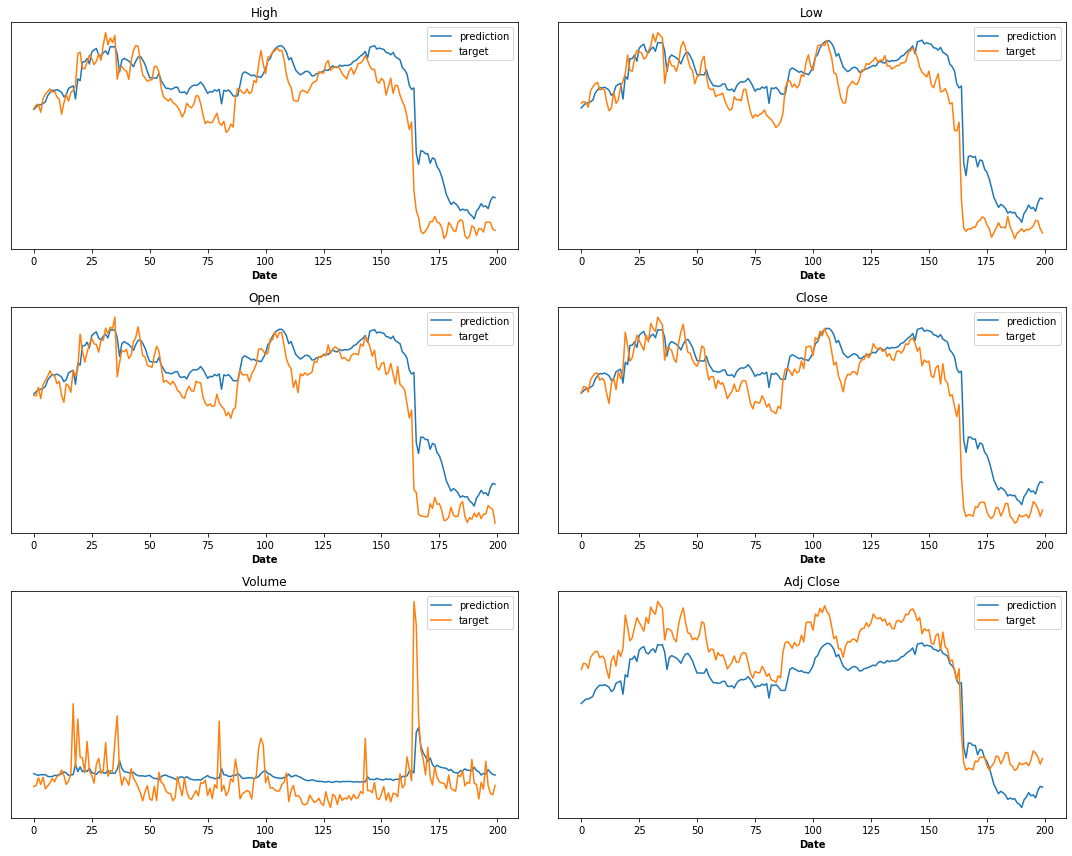

In [13]:
plot(result, y_test, apple_stock)

In [14]:
pred1, targ1= tendency_predict(100,x_test )
print(pred1.shape)
print(targ1.shape)

(100, 6)
(100, 6)


In [16]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(targ1, pred1))
print(rmse)

0.045180328627799776
